# Binary classification of images with a convolutional DNN

In [46]:
!apt-get install unzip

!pip install -U --no-cache-dir \
  tensorflow==1.13.1 \
  tensorflow-gpu==1.13.1 \
  kaggle \
  pillow \
  scipy

%load_ext tensorboard.notebook

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [ ]:
!echo '{"username":"","key":""}' > /content/kaggle.json \
  && chmod 600 /content/kaggle.json
        
!KAGGLE_CONFIG_DIR=/content/.kaggle kaggle competitions download -c dogs-vs-cats -p /content/data

!unzip -n -q /content/data/train.zip -d /content/data
!unzip -n -q /content/data/test1.zip -d /content/data


The data I have for this problem is a large collection of images containing either a cat or a dog. The sizes of these images vary.

Populating the interactive namespace from numpy and matplotlib
Image count: 25000


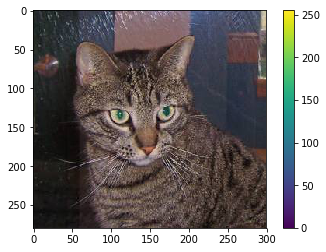

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

original_data_dir = '/content/data/train'

original_data_count = len([name for name in os.listdir(original_data_dir)])
print("Image count: %s" % original_data_count)

img = mpimg.imread(os.path.join(original_data_dir, 'cat.1.jpg'))
imgplot = plt.imshow(img)
plt.colorbar()
plt.show()

I want to make this a small data problem so I'll seperate the training data into three collections. A training set of 1000. A validation set of 500. And, a validation set of 500. Sub directories are added the two class as I'll be using Keras's ImageDataGenerator to read in the images.

In [2]:
import shutil

base_dir = '/content/data/cats-dogs-small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

try:
    os.mkdir(base_dir)

    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)

    os.mkdir(train_cats_dir)
    for i in range(1000):
        src = os.path.join(original_data_dir, 'cat.%s.jpg') % i
        dst = os.path.join(train_cats_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)        
    
    os.mkdir(train_dogs_dir)
    for i in range(1000):
        src = os.path.join(original_data_dir, 'dog.%s.jpg') % i
        dst = os.path.join(train_dogs_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    os.mkdir(validation_cats_dir)
    for i in range(1000, 1500):
        src = os.path.join(original_data_dir, 'cat.%s.jpg') % i
        dst = os.path.join(validation_cats_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    
    os.mkdir(validation_dogs_dir)
    for i in range(1000, 1500):
        src = os.path.join(original_data_dir, 'dog.%s.jpg') % i
        dst = os.path.join(validation_dogs_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    
    os.mkdir(test_cats_dir)
    for i in range(1500, 2000):
        src = os.path.join(original_data_dir, 'cat.%s.jpg') % i
        dst = os.path.join(test_cats_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)

    
    os.mkdir(test_dogs_dir)
    for i in range(1500, 2000):
        src = os.path.join(original_data_dir, 'dog.%s.jpg') % i
        dst = os.path.join(test_dogs_dir, '%s.jpg') % i
        shutil.copyfile(src, dst)
except:
    pass

# check image collections are sized correctly
print('Train cats: %s' % len(os.listdir(train_cats_dir)))
print('Train dogs: %s' % len(os.listdir(train_dogs_dir)))
print('Validate cats: %s' % len(os.listdir(validation_cats_dir)))
print('Validate dogs: %s' % len(os.listdir(validation_dogs_dir)))
print('Test cats: %s' % len(os.listdir(test_cats_dir)))
print('Test dogs: %s' % len(os.listdir(test_dogs_dir)))

Train cats: 1000
Train dogs: 1000
Validate cats: 500
Validate dogs: 500
Test cats: 500
Test dogs: 500


Images in JPEG format really aren't suitable inputs fore the model. They need reworked into tensors. Decoding a JPEG into a bitmap gives me a tensor with shape (150, 150, 3).

In [15]:
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255) # rescale
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


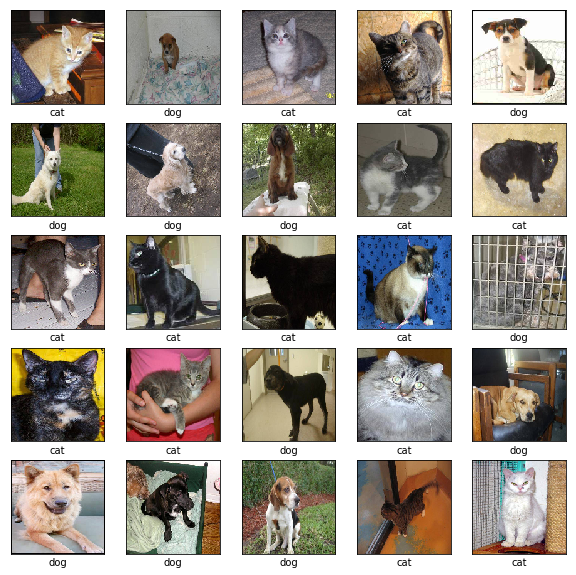

In [29]:
for x_batch, y_batch in train_generator:
    images = x_batch
    labels = list(map(lambda x: 'dog' if x == 1.0 else 'cat', y_batch))
    break

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(labels[i])

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

model = Sequential([
    Conv2D(4, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
             optimizer='RMSprop',
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 148, 148, 4)       112       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 74, 74, 4)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 72, 72, 8)         296       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 34, 34, 16)        1168      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 15, 15, 16)        2320      
__________

In [50]:
from tensorflow.keras.callbacks import TensorBoard

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[TensorBoard('logs/Conv')]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
63/63 [==============================] - 28s 442ms/step - loss: 0.6913 - acc: 0.5130 - val_loss: 0.6736 - val_acc: 0.6150
Epoch 2/30
63/63 [==============================] - 26s 408ms/step - loss: 0.6586 - acc: 0.6130 - val_loss: 0.6444 - val_acc: 0.6240
Epoch 3/30
63/63 [==============================] - 26s 419ms/step - loss: 0.6300 - acc: 0.6440 - val_loss: 0.6183 - val_acc: 0.6650
Epoch 4/30
63/63 [==============================] - 27s 429ms/step - loss: 0.6043 - acc: 0.6700 - val_loss: 0.6596 - val_acc: 0.6160
Epoch 5/30
63/63 [==============================] - 30s 477ms/step - loss: 0.5827 - acc: 0.6885 - val_loss: 0.6307 - val_acc: 0.6520
Epoch 6/30
63/63 [==============================] - 25s 398ms/step - loss: 0.5648 - acc: 0.7050 - val_loss: 0.5856 - val_acc: 0.6940
Epoch 7/30
63/63 [==============================] - 24s 383ms/step - loss: 0.5403 - acc: 0.7340 - val_loss: 0.5751 - val_acc: 0.6930
Epoch 8/30
63/63 [===

In [47]:
%tensorboard --logdir logs/